# Quantitative Analysis of Mortgage
- Date : 09/22/2021

The goal of this notebook is to perform extensive quantitative analysis to answer the following questions
1. For a given loan amount and interest rate , what is the monthly mortgage payment needed ?
-  Based on the current salary , is the monthly mortgage payment affordable ?
- Based on current salary (subjected to salary hike assumptions), how long would it take to repay the loan amount ?
- Based the the time it takes to repay the loan , what is the total interest paid ? This would given an idea about the appreciation of house price needed to gain profit from selling the house.  
(**Bottom Line** : The appreciation of house > Total interest paid on the loan)
- Based on the time it takes to repay the loan , which mortage plan is opt for ? Would 30 year ARM be a better option than 30 year fixed ?

Note : All calculations are in USD

# Amortization Math

$x$ = Monthly payment towards mortgage payment  
$P$ = Loan amount   
$P_j$ = Principal component of $x$ for month $j$  
$I_j$ = Interest component of $x$ for month $j$  
$N$ = Number of installments in the loan term (usually 30 yrs * 12 = 360 installments)  
$i$ = Interest rate per month

Assuming all the payments are the same amount   
$x = P_j + I_j$

The recursive relation for interest calculation  
$I_1 = iP$  
$I_2 = i(P - P_1)$  
$I_3 = i(P - P_1 - P_2)$  
$I_N = i(P - P_1 - P_2 - ..... - P_{N-1})$

The recursive relation for principal calculation  
$P_1 = x - I_1 = (x - iP)$  
$P_2 = x - I_2 = x - i(P - P_1) = (x - iP)(1+i)$    
$P_3 = x - I_3 = (x-iP)(1+i)^{2}$  
$P_N = x - I_N = (x-iP)(1+i)^{N-1}$

Total mortage payment done = principal + total interest paid  
$Nx = P + \sum_{j=1}^{N}I_{j}$

**Bottom Line : Pay an amount > x and contribute more towards $P_j$ , thereby reducing the total interest paid**

# Salary growth assumptions
- ESPP excluded from this analysis
- Salary hike occurs once a year (about 3% growth assumed per annum)
- Combined bonus (husband + wife) assumed to be \$15000 per annum
- Monthly Bills assumed to be \$2000
- Monthly investments assumed to be $1500 - $2000

Amount available towards mortgage payment = salary - monthly_bills - investments

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Constants

In [36]:
# Home price excluding closing charges
HOME_PRICE = 232000

# Down payment affordable based on current savings/investments
DOWN_PAYMENT = 46400

# Rate of interest for the duration of the loan (Assum Fixed interest rate mortgage)
RATE_OF_INTEREST = 2.75

# Term of the loan over which interest is applied
LOAN_TERM = 10

# Home owners association fees (Not all houses have this)
HOA = 0

# Property tax depending on the region 
PROPERTY_TAX = 0

LOAN_AMOUNT = HOME_PRICE - DOWN_PAYMENT

print(f"Yearly interest rate = {RATE_OF_INTEREST:0.3f}%")
print(f"Monthly interest rate = {RATE_OF_INTEREST/12:0.3f}%")
print(f"PROPERTY_TAX : {PROPERTY_TAX}")

Yearly interest rate = 2.750%
Monthly interest rate = 0.229%
PROPERTY_TAX : 0


# Functions

In [37]:
def get_amortization(LOAN_AMOUNT,RATE_OF_INTEREST,LOAN_TERM):
    
    """
    This function return the monthly mortage payment needed as per the amortization scheme
    (Note : This is the minimum amount that needs to be spent per month towards mortgage payment)
    """
    
    i = RATE_OF_INTEREST / (12*100)
    N = 12 * LOAN_TERM
    x = LOAN_AMOUNT * ( (i*(1+i)**N) / (((1+i)**N) - 1) )
    return x
    
def model_mortgage_payment(LOAN_AMOUNT,RATE_OF_INTEREST,df_monthly_payment,MORTGAGE_PAYMENT,ADDITIONAL_EXPENSES=0):
    
    P_list = [0]
    I_list = [0]
    x_list = list(df_monthly_payment.affordable_monthly_payment)

    i = RATE_OF_INTEREST / (12*100)
    
    count = 0
    error_count = 0
    while sum(P_list) < LOAN_AMOUNT:
        x = x_list[count] - ADDITIONAL_EXPENSES
        
        # Check if funds are sufficient
        if x < MORTGAGE_PAYMENT:
            print(f"FUNDS NOT SUFFICIENT FOR MONTH {count}. Arrange for ${MONTHLY_PAYMENT-x}")
            error_count = error_count + 1
        
        I = i*(LOAN_AMOUNT - sum(P_list))
        P = x - I
        I_list.append(I)
        P_list.append(P)
        count = count + 1
        
    return error_count , pd.DataFrame({
        "Principal_payment" : P_list,
        "Interest_payment" : I_list
    })

def get_principal(LOAN_AMOUNT,RATE_OF_INTEREST,j,MORTGAGE_PAYMENT):
    i = RATE_OF_INTEREST / (12*100)
    return (MORTGAGE_PAYMENT - i*LOAN_AMOUNT) * ((1+i)**(j-1))

# Obtain Amortized payment

In [38]:
MORTGAGE_PAYMENT = get_amortization(LOAN_AMOUNT,RATE_OF_INTEREST,LOAN_TERM)
MONTHLY_PAYMENT = MORTGAGE_PAYMENT + HOA + PROPERTY_TAX

principal_variation = [get_principal(LOAN_AMOUNT,RATE_OF_INTEREST,k,MORTGAGE_PAYMENT) for k in range(1,LOAN_TERM*12)]
interest_variation = [MORTGAGE_PAYMENT - get_principal(LOAN_AMOUNT,RATE_OF_INTEREST,k,MORTGAGE_PAYMENT) for k in range(1,LOAN_TERM*12)]

print(f"Mortgage Payment = $ {MORTGAGE_PAYMENT:0.0f}")
print(f"Total monthly payment towards house = $ {MONTHLY_PAYMENT:0.0f}")

Mortgage Payment = $ 1771
Total monthly payment towards house = $ 1771


In [39]:
df = pd.DataFrame({
    "month" : range(1,LOAN_TERM*12),
    "principal" : principal_variation,
    "interest" : interest_variation
})

Text(0.5,1,'INTEREST RATE (2.75)% ;; LOAN AMOUNT $(185600) ;; LOAN TERM (10 yrs)')

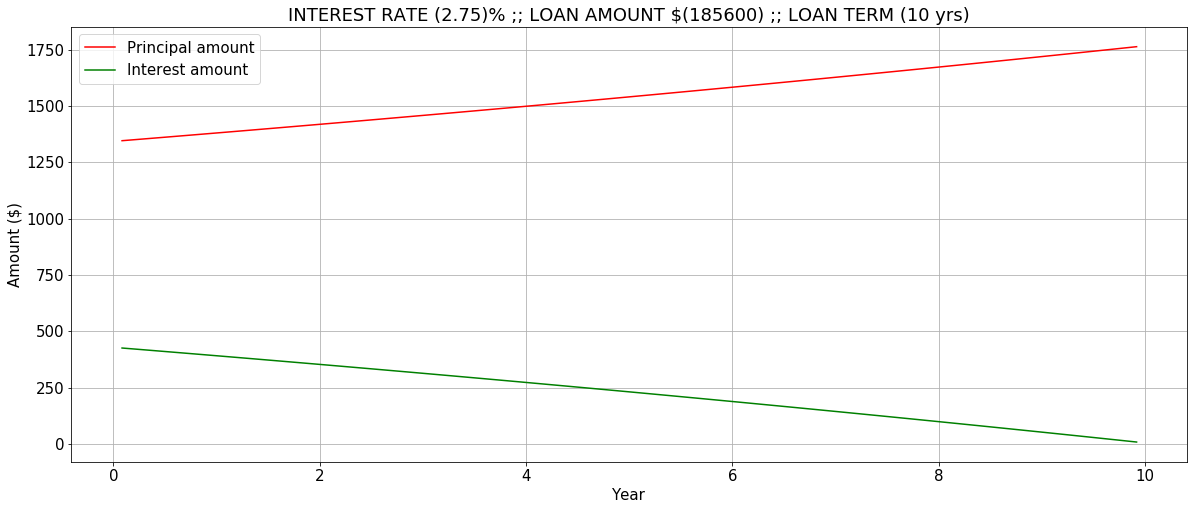

In [40]:
plt.figure(figsize=[20,8])
plt.rc('font', size=15) 
plt.plot(df.month/12,df.principal,'-',color='red',label="Principal amount",markersize=15)
plt.plot(df.month/12,df.interest,'-',color='green',label="Interest amount",markersize=15)
plt.xlabel("Year")
plt.ylabel("Amount ($)")
plt.legend()
plt.grid()
plt.title(f"INTEREST RATE ({RATE_OF_INTEREST})% ;; LOAN AMOUNT $({LOAN_AMOUNT}) ;; LOAN TERM ({LOAN_TERM} yrs)")

## Observations
- During initial months of mortage payment , principal component is lesser than the interest component
- As the principal is paid , the interest paid reduces and eventually becomes zero. 

# Model monthly payment

In [41]:
# Duration to model salary growth
N = LOAN_TERM * 12

# Fortnightly salary of person 1 in USD (after TAX and other deductions)
salary_1 = 2000

# Fortnightly salary of person 2 in USD (after TAX and other deductions)
salary_2 = 0

# Total montly salary of the household
total_salary = 2*(salary_1 + salary_2)

# Monthly bills which includes groceries , fuel , insurance etc
monthly_bills = 1000

# Monthly savings and investments for other financial goals
savings = sum([500,500])

# Salary hike percentage per annum
salary_hike_pct = 2.0

# Annual bonus of the house hold per annum (after TAX)
annual_bonus = 5000

In [42]:
df_monthly_payment = pd.DataFrame({
    "month" : np.arange(N)+1,
    "total_salary" : N*[total_salary]
}) 

df_monthly_payment["year"] = df_monthly_payment.month // 12
df_monthly_payment["total_salary_hiked"] = df_monthly_payment.total_salary * (1 + salary_hike_pct/100)**df_monthly_payment.year
df_monthly_payment["amount_after_expenses"] = df_monthly_payment["total_salary_hiked"] - monthly_bills - savings
df_monthly_payment["is_appraisal"] = df_monthly_payment["month"] % 12 == 0
df_monthly_payment["is_appraisal"] = df_monthly_payment["is_appraisal"].apply(lambda x : int(x))
df_monthly_payment["affordable_monthly_payment"] = df_monthly_payment["amount_after_expenses"] + (annual_bonus*df_monthly_payment["is_appraisal"])

In [43]:
df_monthly_payment.describe()

,month,total_salary,year,total_salary_hiked,amount_after_expenses,is_appraisal,affordable_monthly_payment
count,120.000000,120.0,120.000000,120.000000,120.000000,120.000000,120.000000
mean,60.500000,4000.0,4.583333,4387.188214,2387.188214,0.083333,2803.854881
std,34.785054,0.0,2.897647,251.678039,251.678039,0.277544,1434.081384
min,1.000000,4000.0,0.000000,4000.000000,2000.000000,0.000000,2000.000000
25%,30.750000,4000.0,2.000000,4161.600000,2161.600000,0.000000,2161.600000
50%,60.500000,4000.0,5.000000,4416.323213,2416.323213,0.000000,2416.323213
75%,90.250000,4000.0,7.000000,4594.742671,2594.742671,0.000000,2686.637524
max,120.000000,4000.0,10.000000,4875.977680,2875.977680,1.000000,7875.977680


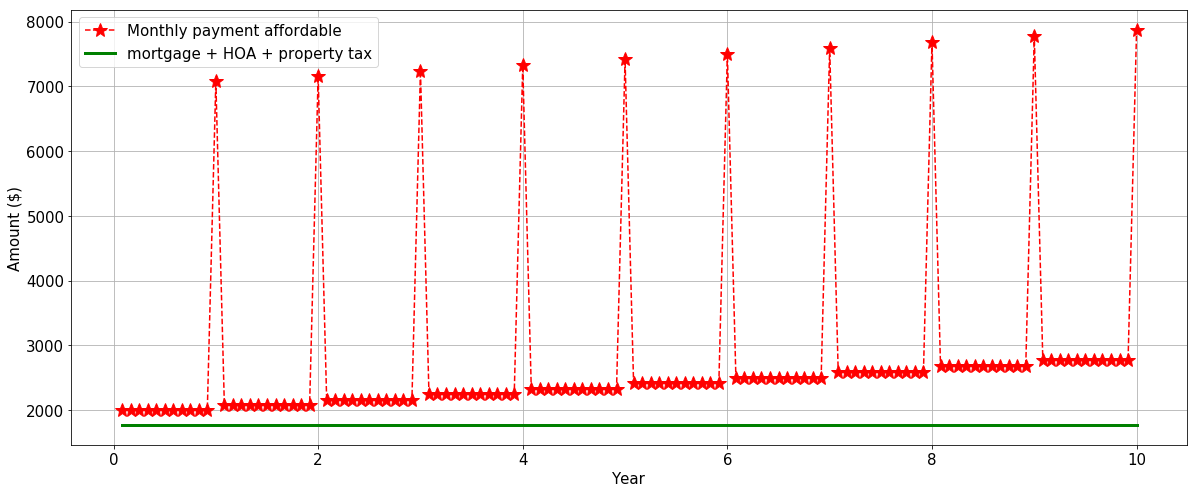

In [44]:
plt.figure(figsize=[20,8])
plt.rc('font', size=15) 
plt.plot(df_monthly_payment.month/12,df_monthly_payment.affordable_monthly_payment,'--r*',label="Monthly payment affordable",markersize=15)
plt.plot(df_monthly_payment.month/12,df_monthly_payment.shape[0]*[MONTHLY_PAYMENT],'-',color='green',label="mortgage + HOA + property tax",linewidth=3.0)
plt.xlabel("Year")
plt.ylabel("Amount ($)")
plt.legend()
plt.grid()

## Things to watch out for !!
- Mortgage payment affordable per month (shown in red) should always be greater than the amortized mortgage payment (shown in green).
- The larger this gap is , the faster one can repay the loan.

In [45]:
df_monthly_payment.describe()

,month,total_salary,year,total_salary_hiked,amount_after_expenses,is_appraisal,affordable_monthly_payment
count,120.000000,120.0,120.000000,120.000000,120.000000,120.000000,120.000000
mean,60.500000,4000.0,4.583333,4387.188214,2387.188214,0.083333,2803.854881
std,34.785054,0.0,2.897647,251.678039,251.678039,0.277544,1434.081384
min,1.000000,4000.0,0.000000,4000.000000,2000.000000,0.000000,2000.000000
25%,30.750000,4000.0,2.000000,4161.600000,2161.600000,0.000000,2161.600000
50%,60.500000,4000.0,5.000000,4416.323213,2416.323213,0.000000,2416.323213
75%,90.250000,4000.0,7.000000,4594.742671,2594.742671,0.000000,2686.637524
max,120.000000,4000.0,10.000000,4875.977680,2875.977680,1.000000,7875.977680


# Let's get real !!
Below section captures the projected montly payment contribution towards mortage payment

In [46]:
error_count , df_mortgage = model_mortgage_payment(LOAN_AMOUNT,RATE_OF_INTEREST,df_monthly_payment,MORTGAGE_PAYMENT,ADDITIONAL_EXPENSES=HOA+PROPERTY_TAX)

In [47]:
NUM_YEARS = df_mortgage.shape[0] / 12
extra_amount = df_mortgage.Interest_payment.sum()

Text(0.5,1,'Model of Mortgage Payment')

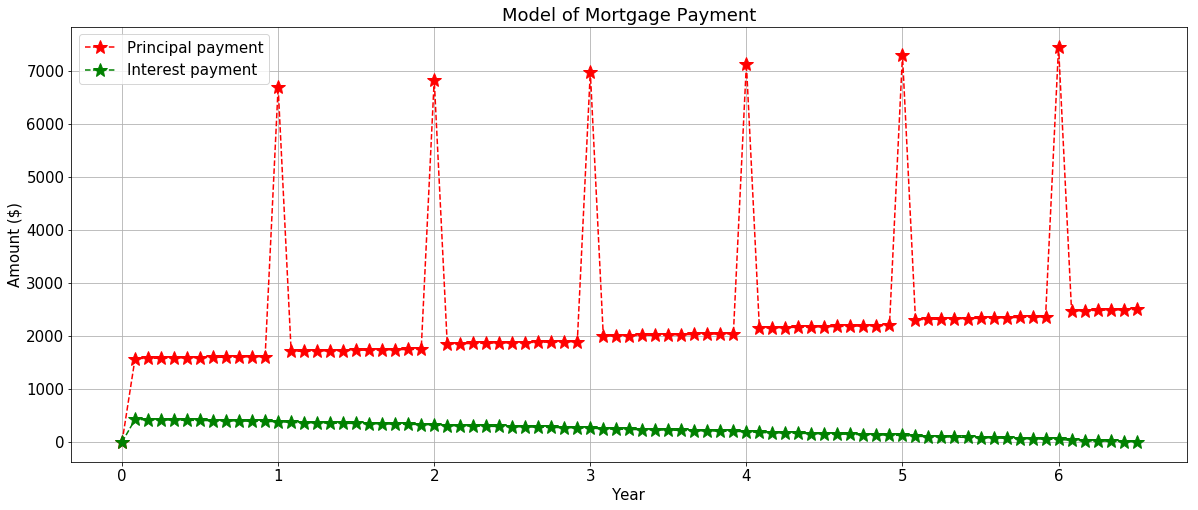

In [48]:
plt.figure(figsize=[20,8])
plt.rc('font', size=15) 
plt.plot(df_mortgage.index/12,df_mortgage.Principal_payment,'--r*',label="Principal payment",markersize=15)
plt.plot(df_mortgage.index/12,df_mortgage.Interest_payment,'--g*',label="Interest payment",markersize=15)
plt.xlabel("Year")
plt.ylabel("Amount ($)")
plt.legend()
plt.grid()
plt.title(f"Model of Mortgage Payment")

In [49]:
print(f"Yearly interest rate = {RATE_OF_INTEREST:0.3f}%")
print(f"Monthly interest rate = {RATE_OF_INTEREST/12:0.3f}%")
print(f"PROPERTY_TAX : {PROPERTY_TAX}")

print(f"\nMortgage Payment = $ {MORTGAGE_PAYMENT:0.0f}")
print(f"Total monthly payment towards house = $ {MONTHLY_PAYMENT:0.0f}")

print(f"\nNumber of years needed to repay loan : {NUM_YEARS:0.2f}")
print(f"Total interest paid : $ {extra_amount:0.0f}")

if (error_count == 0):
    print(f"\nHouse is affordable !!")
else:
    print(f"\nHouse is NOT affordable !!")

Yearly interest rate = 2.750%
Monthly interest rate = 0.229%
PROPERTY_TAX : 0

Mortgage Payment = $ 1771
Total monthly payment towards house = $ 1771

Number of years needed to repay loan : 6.58
Total interest paid : $ 18045

House is affordable !!
